# GNN-2-Message Passing 消息传递神经网络
## 1. Introduction
在图神经网络里面，在对数据和样本之间的关系进行建模得到图的edge， node之后，我们需要在图里面把每个节点的信息根据它的neighbor的信息进行更新，从而达到node的信息更新和节点特征(Node Representation)的特征表达。而这个把node节点信息相互传递从而更新节点表征的方法也叫Message Passing。
MessagePassing是一种聚合邻接节点信息来更新中心节点信息的范式，它将卷积算子推广到了不规则数据领域，实现了图与神经网络的连接。消息传递范式因为简单、强大的特性，于是被人们广泛地使用。遵循消息传递范式的图神经网络被称为消息传递图神经网络。

这一节里面我们讨论和实践 图神经网络一下几点:
+ Message Passing 的原理
+ PyG (PyTorch Geometric)里面的MessagePassing类的理解和改写
+ 通过MessagePassing, GCNConv 搭建Graph Convolution Neural network (GCN) 并通过实际的数据进行训练
+ 对MessagePassing的基类函数如 aggregation， update， 的method进行理解和使用

## 2.How Message Passing works
+ **Message Passing的基本思路**

以图片为例，如果我们的任务是node prediction去预测node A的特征值/node representation，那么图片里node A就是target node。然后 MessagePassing的过程如下
   1. 图中黄色方框部分内容的是一次邻居节点信息传递到中心节点的过程：B节点的邻接节点（A,C）的信息经过变换后聚合到B节点，接着B节点信息与邻居节点聚合信息一起经过变换得到B节点的新的节点信息。同时，分别如红色和绿色方框部分所示，同样的过程，C、D节点的信息也被更新。实际上，同样的过程在所有节点上都进行了一遍，所有节点的信息都更新了一遍。 每个node的值是同时更新的
   2. 把步骤1 的“邻居节点信息传递到中心节点的过程”进行多次。如图中蓝色方框部分所示，A节点的邻接节点（B,C,D）的已经发生过一次更新的节点信息，经过变换、聚合、再变换产生了A节点第二次更新的节点信息。多次更新后的节点信息就作为节点表征。
   3. 一句话总结就是每次都把图里面的node的信息根据邻居节点进行更新，并多次把图的信息不断刷新得到Node representation。

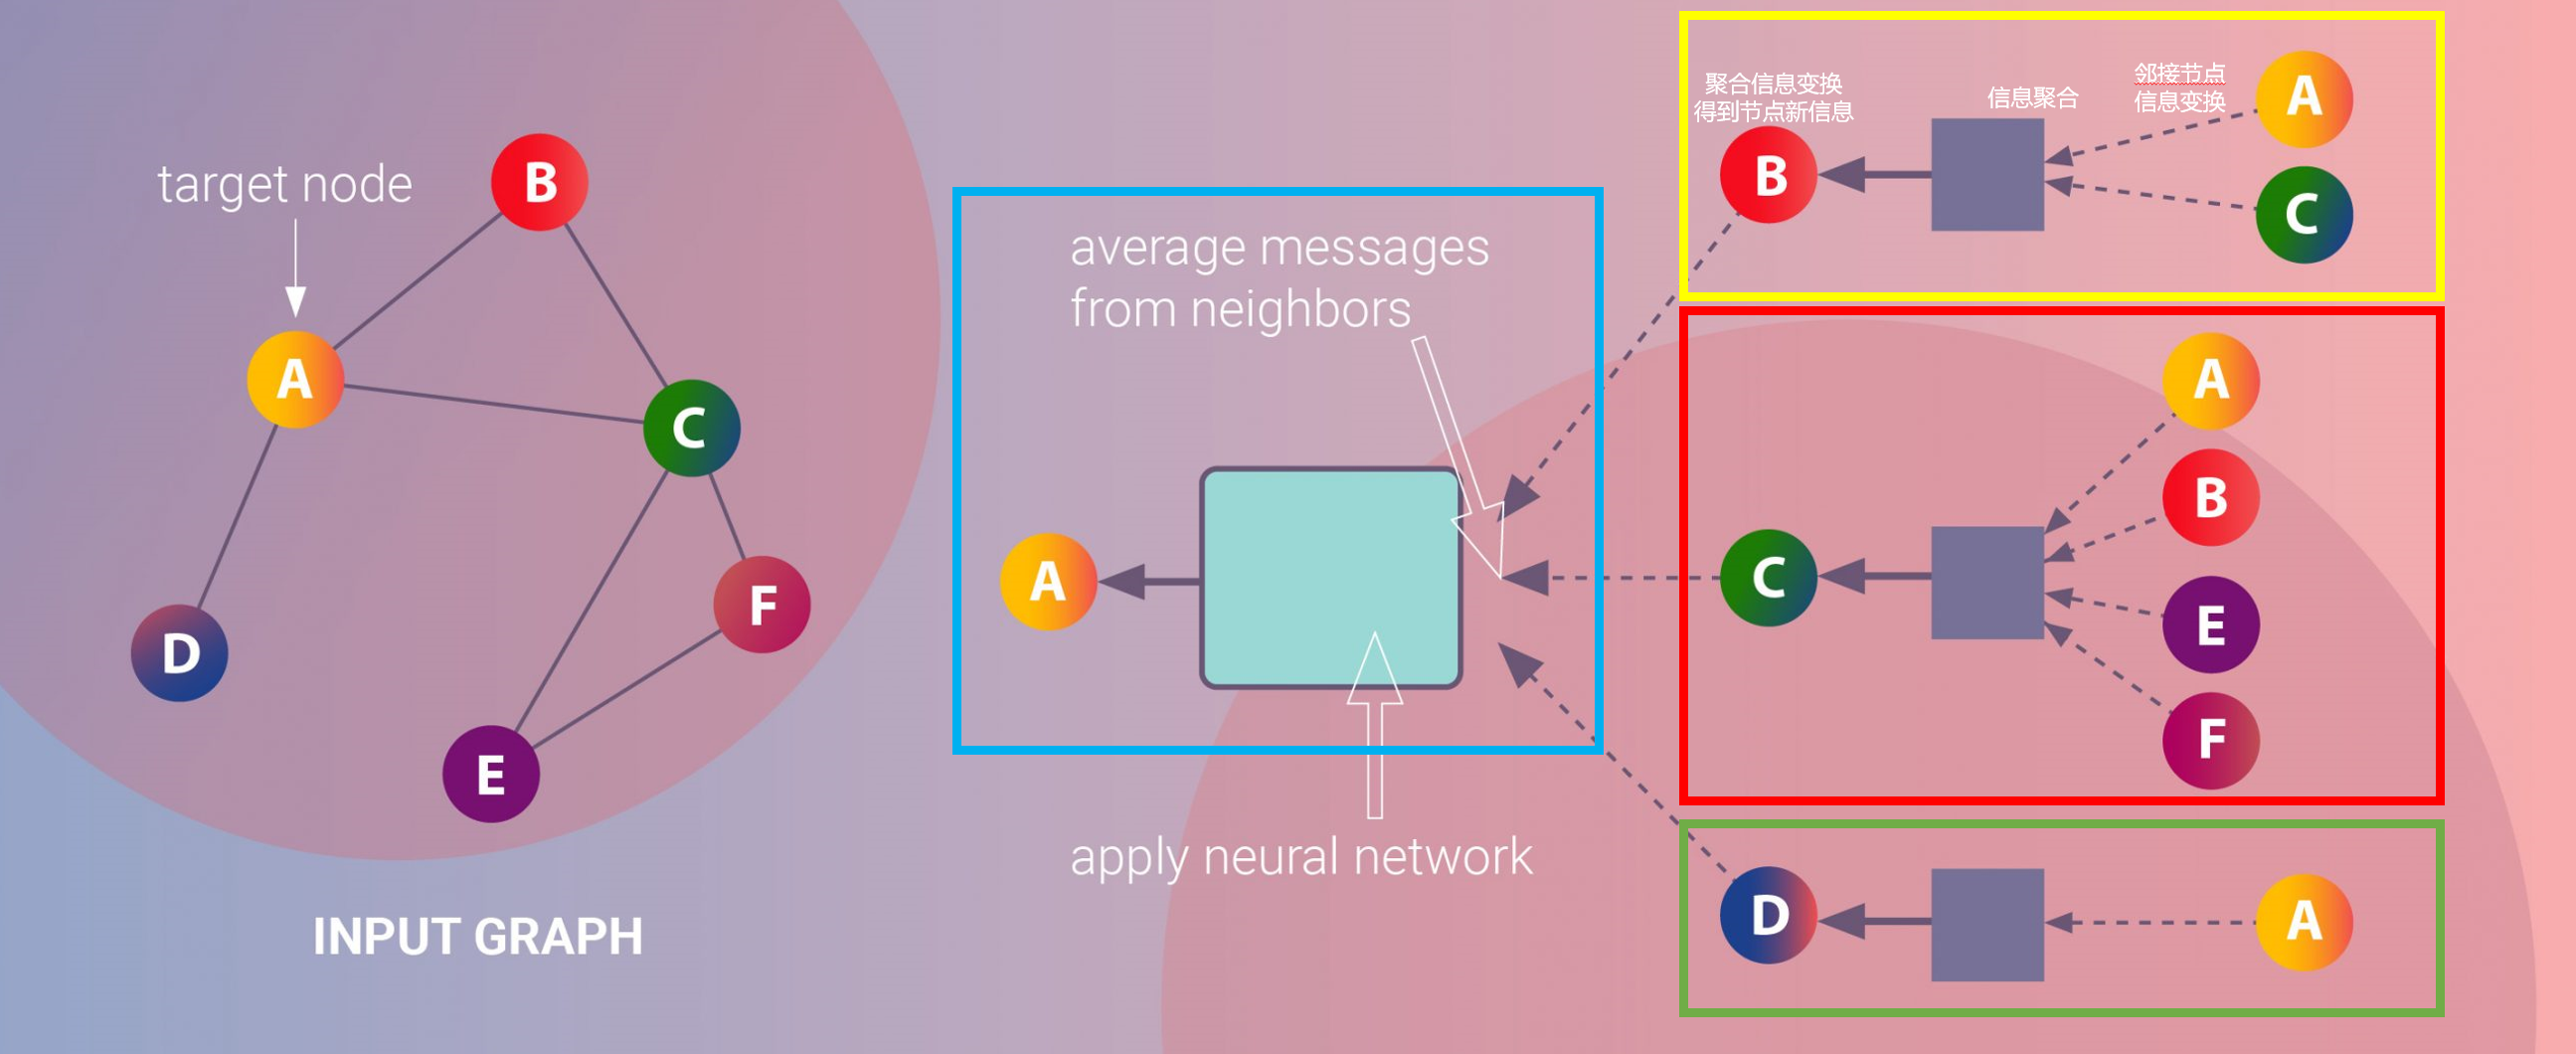

+ **Message Passing GNN 的泛式**

MessagePassing图神经网络遵循上述的“聚合邻接节点信息来更新中心节点信息的过程”，来生成节点表征。**Message Passing GNN的通用公式可以描述为**
$$
\mathbf{x}_i^{(k)} = \gamma^{(k)} \left( \mathbf{x}_i^{(k-1)}, \square_{j \in \mathcal{N}(i)} \, \phi^{(k)}\left(\mathbf{x}_i^{(k-1)}, \mathbf{x}_j^{(k-1)},\mathbf{e}_{j,i}\right) \right),
$$

根据[官方文档](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html) 以及[CREATING MESSAGE PASSING NETWORKS](https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html#creating-message-passing-networks), 我们定义
+ $\mathbf{x}^{(k-1)}_i\in\mathbb{R}^F$表示神经网络的$(k-1)$层中节点$i$的节点表征
+ $\mathbf{e}_{j,i} \in \mathbb{R}^D$ 表示从节点$j$到节点$i$的边的属性信息。
+ $\square$表示**可微分**的、具有排列不变性（**函数输出结果与输入参数的排列无关**）的函数, 比如aggregation 函数。比如sum， mean, min等函数和输入的参数顺序无关的函数。
+ $\gamma$ : **可微分可导**的update 函数，比如MLPs（多层感知器）
+ $\phi$: **可微分可导**的message 函数，比如MLPs（多层感知器）和 linear Projection等

+ **Note:**
    1. 神经网络的生成节点表征的操作称为节点嵌入（Node Embedding），节点表征也可以称为节点嵌入。**这里考虑节点嵌入只代指神经网络生成节点表征的操作**。

    2. 未经过训练的图神经网络生成的节点表征还不是好的节点表征，好的节点表征可用于衡量节点之间的相似性。通过监督学习对图神经网络做很好的训练，图神经网络才可以生成好的节点表征。我们将在[第5节](5-基于图神经网络的节点表征学习.md)介绍此部分内容。

    3. 节点表征与节点属性的区分：遵循被广泛使用的约定，此次组队学习我们也约定，节点属性`data.x`是节点的第0层(GNN输入层)节点表征，第$h$层的节点表征经过一次的节点间信息传递产生第$h+1$层的节点表征。不过，节点属性不单指`data.x`，广义上它就指节点的属性，如节点的度(in-degree, out-degree)等。


## 3. MessagePassing Class in PyTorch Geometric
Pytorch Geometric(PyG)提供了MessagePassing基类，它封装了“消息传递”的运行流程。通过继承MessagePassing基类，可以方便地构造消息传递图神经网络。构造一个最简单的消息传递图神经网络类，我们只需定义message()方法（ 𝜙(..) ）、update()方法（ 𝛾(..) ），以及使用的消息聚合方案（aggr="add"、aggr="mean"或aggr="max"。**MessagePassing Base Class中这里最重要的3个函数是：**
+ `MessagePassing.aggregate(...)`：用于处理聚集到节点的信息的函数
+ `MessagePassing.message(...)`：用于搭建传送到 node i的节点消息，相对于𝜙(..)函数
+ `MessagePassing.update(aggr_out, ...)`: 用于更新节点的信息，相对于𝛾(..)
    
**以下是一些常用函数的解释:**
+ `MessagePassing(aggr="add", flow="source_to_target", node_dim=-2)`: 
    + `aggr`: aggregation function聚合函数的选项, 可以用 ("add", "mean" or "max")
    + `flow`: 信息传递方向 (either "source_to_target" or "target_to_source")
    + `node_dim`：定义沿着哪个维度传播，默认值为-2，也就是节点表征张量（data.x, Tensor）的哪一个维度是节点维度。节点表征张量x形状为[num_nodes, num_features]，其第0维度/columns（也是第-2维度）是节点维度(节点的个数)，其第1维度（也是第-1维度）是节点表征维度，所以我们可以设置node_dim=-2。

+ `MessagePassing.propagate(edge_index, size=None, **kwargs)`: 
    + `edge_index`: 一个matrix存放每条edge 的索引信息(起始和终止的node的index)
    + `size`: 基于非对称的邻接矩阵进行消息传递（当图为二部图时），需要传递参数size=(N, M)。如果size=None, 默认邻接矩阵是对称的
    + `**kwargs`：图的其他特征

+ `MessagePassing.message(...)`：
  - 首先确定要给节点$i$传递消息的边的集合：
    - 如果`flow="source_to_target"`，则是$(j,i) \in \mathcal{E}$的边的集合；
    - 如果`flow="target_to_source"`，则是$(i,j) \in \mathcal{E}$的边的集合。
  - 接着为各条边创建要传递给节点$i$的消息，即实现$\phi$函数。
  - `MessagePassing.message(...)`方法可以接收传递给`MessagePassing.propagate(edge_index, size=None, **kwargs)`方法的所有参数，我们在`message()`方法的参数列表里定义要接收的参数，例如我们要接收`x,y,z`参数，则我们应定义`message(x,y,z)`方法。
  - 传递给`propagate()`方法的参数，如果是节点的属性的话，可以被拆分成属于中心节点的部分和属于邻接节点的部分，只需在变量名后面加上`_i`或`_j`。例如，我们自己定义的`meassage`方法包含参数`x_i`，那么首先`propagate()`方法将节点表征拆分成中心节点表征和邻接节点表征，接着`propagate()`方法调用`message`方法并传递中心节点表征给参数`x_i`。而如果我们自己定义的`meassage`方法包含参数`x_j`，那么`propagate()`方法会传递邻接节点表征给参数`x_j`。
  - 我们用$i$表示“消息传递”中的中心节点，用$j$表示“消息传递”中的邻接节点。
  
+ `MessagePassing.aggregate(...)`：
  - 将从源节点传递过来的消息聚合在目标节点上，一般可选的聚合方式有`sum`, `mean`和`max`。
+ `MessagePassing.message_and_aggregate(...)`：
  - 在一些场景里，邻接节点信息变换和邻接节点信息聚合这两项操作可以融合在一起，那么我们可以在此方法里定义这两项操作，从而让程序运行更加高效。
+ `MessagePassing.update(aggr_out, ...)`: 
  - 为每个节点$i \in \mathcal{V}$更新节点表征，即实现$\gamma$函数。此方法以`aggregate`方法的输出为第一个参数，并接收所有传递给`propagate()`方法的参数。



## 4. Coding Practice
### 4.1 基于 Message Passing的泛式(框架)搭建Graph Convolution Network (GCN)

根据PyG的官方文档，**[`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv)** 的公式是
$$
\mathbf{x}_i^{(k)} = \sum_{j \in \mathcal{N}(i) \cup \{ i \}} \frac{1}{\sqrt{\deg(i)} \cdot \sqrt{\deg(j)}} \cdot \left( \mathbf{\Theta} \cdot \mathbf{x}_j^{(k-1)} \right),
$$
其中，$\mathbf{x}_i$ 的节点的特征是由它的近邻的node的信息(包括node i自己)进行更新，所以计算时j是节点i的邻居(包括节点i本身)的子集里面的node。 邻接节点的表征$\mathbf{x}_j^{(k-1)}$首先通过与权重矩阵$\mathbf{\Theta}$相乘进行变换，然后按端点的度$\deg(i), \deg(j)$进行归一化处理，最后进行求和。这个公式可以分为以下几个步骤：

1. 向邻接矩阵添加自环边。
1. 对节点表征做线性转换。
1. 计算归一化系数。
1. 归一化邻接节点的节点表征。
1. 将相邻节点表征相加（"求和 "聚合）。

步骤1-3通常是在消息传递发生之前计算的。步骤4-5可以使用[`MessagePassing`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.message_passing.MessagePassing)基类轻松处理。该层的全部实现如下所示。



In [1]:
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
import torch


class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(GCNConv, self).__init__(aggr='add')  # "Add" aggregation (Step 5).
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Step 1: Add self-loops to the adjacency matrix.
        # Adds a self-loop (i,i)∈E to every node i∈V in the graph given by edge_index.
        # In case the graph is weighted, self-loops will be added with edge weights denoted by fill_value.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Linearly transform node feature matrix.
        x = self.lin(x)

        # Step 3: Compute normalization: 1/sqrt(degree(i)) * 1/sqrt(degree(j))
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4-5: Start propagating messages.
        return self.propagate(edge_index, x=x, norm=norm)

    def message(self, x_j, norm):
        # x_j has shape [E, out_channels]

        # Step 4: Normalize node features.
        return norm.view(-1, 1) * x_j

    


In [2]:
## download data to current directory
#! wget https://github.com/kimiyoung/planetoid/raw/master/data/ind.cora.x

In [3]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='./dataset/Cora', name='Cora')
data = dataset[0]
# GCNConv: 
#in_channels: dimension of input vector of linear layer
# out_channels: dimension of output vector of linear layer
#Note: the linear transform is performed before message passing to reduce the dimension of node representation
# After message passing, the amount of nodes doesn't change
net = GCNConv(data.num_features, 64)

# data.x: a matrix with each row representing the data in a node
# data.edge_index: matrix with shape [2, number of edges], each column representing edge from node to another node, value=index of node
h_nodes = net(data.x, data.edge_index)
print(h_nodes.shape)

torch.Size([2708, 64])


In [4]:
data.x.shape

torch.Size([2708, 1433])

### 4.2 Overwrite methods: messsage, aggregate, update

In [10]:
from torch_geometric.datasets import Planetoid
import torch
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
from torch_sparse import SparseTensor


class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(GCNConv, self).__init__(aggr='add', flow='source_to_target')
        # "Add" aggregation (Step 5).
        # flow='source_to_target' 表示消息从源节点传播到目标节点
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Step 1: Add self-loops to the adjacency matrix.
        print("Before self-loop:",edge_index.shape)
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        print("After self-loop:",edge_index.shape)
        # Step 2: Linearly transform node feature matrix.
        x = self.lin(x)

        # Step 3: Compute normalization.
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4-5: Start propagating messages.
        # Convert edge index to a sparse adjacency matrix representation, with row = from nodes, col = to nodes, value = 0 or 1 indicating if
        # two nodes are adjacent.
        adjmat = SparseTensor(row=edge_index[0], col=edge_index[1], value=torch.ones(edge_index.shape[1]))
        #print("Adjacency matrix:",adjmat)
        # 此处传的不再是edge_idex，而是SparseTensor类型的Adjancency Matrix
        return self.propagate(adjmat, x=x, norm=norm, deg=deg.view((-1, 1)))

    def message(self, x_j, norm, deg_i):
        # x_j has shape [E, out_channels]
        # deg_i has shape [E, 1]
        # Step 4: Normalize node features.
        return norm.view(-1, 1) * x_j * deg_i

    def aggregate(self, inputs, index, ptr, dim_size):
        print('self.aggr:', self.aggr)
        print("`aggregate` is called")
        return super().aggregate(inputs, index, ptr=ptr, dim_size=dim_size)

    def message_and_aggregate(self, adj_t, x, norm):
        print('`message_and_aggregate` is called')
        # 没有实现真实的消息传递与消息聚合的操作

    def update(self, inputs, deg):
        print(deg)
        return inputs


dataset = Planetoid(root='dataset/Cora', name='Cora')
data = dataset[0]

net = GCNConv(data.num_features, 64)
h_nodes = net(data.x, data.edge_index)
# print(h_nodes.shape)

Before self-loop: torch.Size([2, 10556])
After self-loop: torch.Size([2, 13264])
Adjacency matrix: SparseTensor(row=tensor([   0,    0,    0,  ..., 2707, 2707, 2707]),
             col=tensor([   0,  633, 1862,  ..., 1473, 2706, 2707]),
             val=tensor([1., 1., 1.,  ..., 1., 1., 1.]),
             size=(2708, 2708), nnz=13264, density=0.18%)
`message_and_aggregate` is called
tensor([[4.],
        [4.],
        [6.],
        ...,
        [2.],
        [5.],
        [5.]])


### 5. Assignment
#### 5.1 **Message Passing 机制总结**
Message Passing 根据上面讨论的的框架公式，在设计Message Passing 的流程可以归纳为以下几点:
1. 定义和选取 message 函数，𝜙(..)，并根据图的节点信息的输入($x_i^{k-1}, x_j^{k-1}, e_{i,j}$) 对输入进行变换(可导的，比如线性投映进行降维或乘上系数之类的)
2. 定义和选取 aggregation 函数 $\square(..)$, 对转换后的信息进行邻居节点的信息聚合处理， 常用的有sum, mean, max之类的
3. 定义和选取update()函数（ 𝛾(..) ），把原本的节点信息$x_i^{k-1}$ 和 聚合后的邻居节点信息($\square(..)$ 函数的输出)的信息进行整合，更新当前的节点信息得到$x_j^{k}$。

用GCN的公式举个栗子，就是 
$$
\mathbf{x}_i^{(k)} = \sum_{j \in \mathcal{N}(i) \cup \{ i \}} \frac{1}{\sqrt{\deg(i)} \cdot \sqrt{\deg(j)}} \cdot \left( \mathbf{\Theta} \cdot \mathbf{x}_j^{(k-1)} \right),
$$

+ GCN里面的 $\frac{1}{\sqrt{\deg(i)} \cdot \sqrt{\deg(j)}} \cdot \left( \mathbf{\Theta} \cdot \mathbf{x}_j^{(k-1)} \right)$ 的操作，里面的$\mathbf{\Theta}$ 线性投映和用degree做normalization相对于是 𝜙(..)函数的message的搭建

+ 而 $\sum_{j \in \mathcal{N}(i) \cup \{ i \}}$ 这一步相对于把邻居节点(包括节点自己)的信息进行聚合, 相对于aggregation 函数 $\square(..)$
+ GCN这里因为在做了aggregation后没有用到 $x_i^{k-1}$信息，所以update()函数, 𝛾($x_i^{k-1}, \square(..)$) 可以看成直接输出(或者是$\square()$信息聚合后乘上1就输出)。𝛾(..)其实也可以替换为其他可导的的非线性函数比如 logistics， relu之类的。
+ 至于MessagePassing 的Base Class里面的message_and_aggregate()可以看成是 $\square(\phi(x_i^{k-1}, x_j^{k-1}, e_{i,j}))$
+ MessagePassing 的Base Class里面的propagate()函数可以看成是对 $\gamma(x_i^{k-1}, \square(\phi(...)))$ 更新函数的封装。 这一点可以看看官方文档的[源码](https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/nn/conv/message_passing.html#MessagePassing.propagate)


#### 5.2 **用MessagePassing 这个BaseClass去实现一个 我自定义的GCN layer**
这里我自定义的GCN layer公式如下：
$$
\mathbf{x}_i^{(k)} = \sigma(\frac{1}{|\mathcal{N}(i)|+1} \times \sum_{j \in \mathcal{N}(i) \cup \{ i \}} \frac{1}{\sqrt{\deg(i)} \cdot \sqrt{\deg(j)}} \cdot \left( \mathbf{\Theta} \cdot \mathbf{x}_j^{(k-1)} \right) ) +  \mathbf{\Theta}  \cdot \mathbf{x}_i^{(k-1)} ,
$$

这里一些函数定义如下：
+ $\phi(..)$: message函数和之前的GCN一样都是linear projection之后用degree进行normalization
+ $\square(..)$ : aggregate 函数 用来mean
+ $\gamma(..)$: update 函数是先用了ReLu activation函数, 在加上shortcut把之前投映之后的输入加上来，模拟了resnet的结构
+ 这里只用了 message_and_aggregate 函数，所以没有实现message， aggregate的单独的函数
+ propagate 函数是直接从官方文档copy过来，方便理解GNN的propagate的流程的。 从中可以看到，如果输入到propagate的tensor是SparseTensor, 那么会直接调用message_and_aggregate函数，而不是单独调用两个函数，所以只要实现这个合并的函数就行了

In [175]:
from torch_geometric.datasets import Planetoid
import torch
from torch import nn, Tensor
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
from torch_sparse import SparseTensor, matmul


class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(GCNConv, self).__init__(aggr='mean', flow='source_to_target')
        # "Add" aggregation (Step 5).
        # flow='source_to_target' 表示消息从源节点传播到目标节点
        self.lin = torch.nn.Linear(in_channels, out_channels)
        self.relu = torch.nn.ReLU()

        
    def propagate(self, edge_index, size=None, **kwargs):
        # I just copy the source copy from PyG website
        r"""The initial call to start propagating messages.

        Args:
            edge_index (Tensor or SparseTensor): A :obj:`torch.LongTensor` or a
                :obj:`torch_sparse.SparseTensor` that defines the underlying
                graph connectivity/message passing flow.
                :obj:`edge_index` holds the indices of a general (sparse)
                assignment matrix of shape :obj:`[N, M]`.
                If :obj:`edge_index` is of type :obj:`torch.LongTensor`, its
                shape must be defined as :obj:`[2, num_messages]`, where
                messages from nodes in :obj:`edge_index[0]` are sent to
                nodes in :obj:`edge_index[1]`
                (in case :obj:`flow="source_to_target"`).
                If :obj:`edge_index` is of type
                :obj:`torch_sparse.SparseTensor`, its sparse indices
                :obj:`(row, col)` should relate to :obj:`row = edge_index[1]`
                and :obj:`col = edge_index[0]`.
                The major difference between both formats is that we need to
                input the *transposed* sparse adjacency matrix into
                :func:`propagate`.
            size (tuple, optional): The size :obj:`(N, M)` of the assignment
                matrix in case :obj:`edge_index` is a :obj:`LongTensor`.
                If set to :obj:`None`, the size will be automatically inferred
                and assumed to be quadratic.
                This argument is ignored in case :obj:`edge_index` is a
                :obj:`torch_sparse.SparseTensor`. (default: :obj:`None`)
            **kwargs: Any additional data which is needed to construct and
                aggregate messages, and to update node embeddings.
        """
        size = self.__check_input__(edge_index, size)

        # Run "fused" message and aggregation (if applicable).
        if (isinstance(edge_index, SparseTensor) and self.fuse
                and not self.__explain__):
            coll_dict = self.__collect__(self.__fused_user_args__, edge_index,
                                         size, kwargs)
            print("Using self-defined message-passing")
            msg_aggr_kwargs = self.inspector.distribute(
                'message_and_aggregate', coll_dict)
            out = self.message_and_aggregate(edge_index, **msg_aggr_kwargs)

            update_kwargs = self.inspector.distribute('update', coll_dict)
            return self.update(out, **update_kwargs)

        # Otherwise, run both functions in separation.
        elif isinstance(edge_index, Tensor) or not self.fuse:
            coll_dict = self.__collect__(self.__user_args__, edge_index, size,
                                         kwargs)

            msg_kwargs = self.inspector.distribute('message', coll_dict)
            out = self.message(**msg_kwargs)

            # For `GNNExplainer`, we require a separate message and aggregate
            # procedure since this allows us to inject the `edge_mask` into the
            # message passing computation scheme.
            if self.__explain__:
                edge_mask = self.__edge_mask__.sigmoid()
                # Some ops add self-loops to `edge_index`. We need to do the
                # same for `edge_mask` (but do not train those).
                if out.size(self.node_dim) != edge_mask.size(0):
                    loop = edge_mask.new_ones(size[0])
                    edge_mask = torch.cat([edge_mask, loop], dim=0)
                assert out.size(self.node_dim) == edge_mask.size(0)
                out = out * edge_mask.view([-1] + [1] * (out.dim() - 1))

            aggr_kwargs = self.inspector.distribute('aggregate', coll_dict)
            out = self.aggregate(out, **aggr_kwargs)

            update_kwargs = self.inspector.distribute('update', coll_dict)
            return self.update(out, **update_kwargs)
        
        
    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Step 1: Add self-loops to the adjacency matrix.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Linearly transform node feature matrix.
        x = self.lin(x)

        # Step 3: Compute normalization.
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        # note: norm is in shape of (number of edge, )
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        print("Get degree Shape: ", edge_index.shape)
        print("Norm Shape: ",norm.shape)
        
        # Step 4-5: Start propagating messages.
        # Convert edge index to a sparse adjacency matrix representation, with row = from nodes, col = to nodes. 
        # When value =  1 in adjacency matrix, it indicates two nodes are adjacent.
        # adjmat = SparseTensor(row=edge_index[0], col=edge_index[1], value=torch.ones(edge_index.shape[1]))
        
        # 这里 adjacency matrix 的值从1 变成 normalization 的值，方便乘法计算
        adjmat = SparseTensor(row=edge_index[0], col=edge_index[1], value=norm)
        
        # 此处传的不再是edge_idex，而是SparseTensor类型的Adjancency Matrix
        return self.propagate(adjmat, x=x, norm=norm, deg=deg.view((-1, 1)))


    def message(self, x_j, norm, deg_i=1):
        # x_j has shape [E, out_channels]
        # deg_i has shape [E, 1]
        # Step 4: Normalize node features.
        return norm.view(-1, 1) * x_j * deg_i

    def aggregate(self, inputs, index, ptr, dim_size):
        print('self.aggr:', self.aggr)
        print("`aggregate` is called")
        return super().aggregate(inputs, index, ptr=ptr, dim_size=dim_size)

    def message_and_aggregate(self, adj_t, x, norm,deg):
        # note: 
        # adj_t: adjacency matrix
        # norm: normalization coefficient 1/sqrt(deg_i)*sqrt(deg_j)
        # number of '1' in adj_t = length of norm
        
        ## Print something to debug
        #print('`message_and_aggregate` is called')
        #print("adj_t: ",adj_t)
        #print("deg:", deg)
        
        adj_t = adj_t.to_dense()
        N = len(adj_t)
        out = []
        x0 = x[:]
        for i in range(N):
            # 计算每个 xi 的neighbor传过来的信息的平均值
            x_sum = torch.matmul(x.T,adj_t[i])
            x_avg = x_sum/deg[i]
            out.append(x_avg)
        out = torch.stack(out)
        return [out, x0]

    def update(self, inputs, deg):
        print("Update result")
        print("Degree",deg)
        # resnet的结构
        x0 = inputs[1]
        output = self.relu(inputs[0]) + x0
        return output


dataset = Planetoid(root='dataset/Cora', name='Cora')
data = dataset[0]

net = GCNConv(data.num_features, 64)
h_nodes = net(data.x, data.edge_index)


Get degree Shape:  torch.Size([2, 13264])
Norm Shape:  torch.Size([13264])
Using self-defined message-passing
Update result
Degree tensor([[4.],
        [4.],
        [6.],
        ...,
        [2.],
        [5.],
        [5.]])


In [176]:
h_nodes

tensor([[ 1.1262e-04, -6.0657e-02, -2.5644e-02,  ...,  1.2791e-02,
          2.4094e-02,  8.4488e-02],
        [ 9.5781e-02,  3.0109e-02,  1.0536e-01,  ...,  5.9062e-02,
          6.5623e-02,  2.2322e-02],
        [ 1.1685e-01,  1.9822e-02,  1.5696e-01,  ...,  7.2434e-02,
         -1.8062e-02, -2.3522e-02],
        ...,
        [ 8.3955e-02, -1.9041e-03,  8.8832e-02,  ...,  8.1169e-02,
         -2.3039e-02,  7.6098e-02],
        [-6.5679e-03,  9.7862e-03,  3.8410e-02,  ..., -3.0759e-02,
         -5.3772e-03,  1.5986e-01],
        [ 1.6175e-01, -2.3304e-02, -5.7581e-02,  ...,  3.2008e-02,
         -1.7487e-02,  3.8593e-02]], grad_fn=<AddBackward0>)